In [1]:
#Import libraries

import pandas as pd
from pandas import DataFrame
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
import daft

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import theano
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import missingno
import graphviz
from causalgraphicalmodels import CausalGraphicalModel

print("Packages uploaded successfully!")

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Packages uploaded successfully!


In [2]:
#Read dataset
data = pd.read_csv('./dnt_machine_readable.csv')

In [3]:
#Add ID column
data['ID']= data.index + 1
data=data[['ID', 'Chemical', 'CASRN',	'DNT',	'SLogP',	'BBB',	'Cbrain/Cblood',	'Pgp_inhibition', 'Pgp_substrate',	'Pgp_active',	'BDNF, Reduction',	'Activity_Syn',	'Syn_EC30',	'Viability_EC30',	'Activity_NNF',	'NNF EC50min',	'NNF EC50max',	'Viability_LDH' ]]
data.head(5)

,ID,Chemical,CASRN,DNT,SLogP,BBB,Cbrain/Cblood,Pgp_inhibition,Pgp_substrate,Pgp_active,"BDNF, Reduction",Activity_Syn,Syn_EC30,Viability_EC30,Activity_NNF,NNF EC50min,NNF EC50max,Viability_LDH
0,1,5-Fluorouracil,51-21-8,1,-0.7977,1.0,0.199528,0.0,0.0,0.0,1.0,3,NaN,91.8,3,0.46,5.03,3.37
1,2,Acrylamide,79-06-1,1,-0.3423,1.0,0.380063,0.0,0.0,0.0,1.0,1,NaN,NaN,2,8.26,11.30,NaN
2,3,Aldicarb,116-06-3,1,1.4698,1.0,0.609681,0.0,0.0,0.0,NaN,1,NaN,NaN,2,0.66,9.88,NaN
3,4,Aminonicotinamide,329-89-5,1,-0.2373,1.0,0.212859,0.0,0.0,0.0,NaN,2,7.9,6.7,3,3.18,9.85,6.27
4,5,Bisphenol A,80-05-7,1,3.4237,1.0,6.030440,0.0,0.0,0.0,1.0,3,33.9,95.0,2,1.01,25.17,NaN


### Data standardisation

In [ ]:
# ### Kept this step in case we need it later on

#Standardise continuous values
data_prep = data[['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']

#Add other discrete values and details
discrete = data [['ID','Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

### The Adverse Outcome Pathway Network

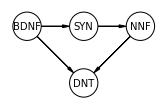

In [4]:
#Causal relationships between the key events
dag_dnt = CausalGraphicalModel(
    nodes=["BDNF", "DNT", "SYN", "NNF"], edges=[("BDNF", "DNT"), ("BDNF", "SYN"), ("NNF", "DNT"), ("SYN", "NNF")]
)
pgm = daft.PGM()
coordinates = {"BDNF": (0, 0), "DNT": (1, 1), "SYN": (1, 0), "NNF": (2, 0)}
for node in dag_dnt.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_dnt.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [5]:
print(dag_dnt.get_distribution())

P(BDNF)P(SYN|BDNF)P(NNF|SYN)P(DNT|BDNF,NNF)


### Entire multilevel model

$$
\mu \sim Normal (0, 1) \\
\sigma \sim Normal (0, 1) \\
\alpha \sim Normal(0, 1) \\
\beta \sim Normal (0, 1) \\
$$
$$
BDNF \sim Bernoulli (p_i)\\
logit(p_i) = \alpha + \beta X_i \\ 
X: {SlogP, BBB, Cbrain/Cblood, Pgp}
$$


$$
SYN \sim OrderedLogistic (n_i, c_1, c_2, c_3, c_4)\\
logit(n_i) = \alpha + \beta X_i\\ 
\ c_1, c_2, c_3, c_4 \sim Normal(0, 1) \\
X: {EC30, Viability}
$$


$$
NNF \sim OrderedLogistic (n_i, c_1, c_2, c_3, c_4, c_5)\\
logit(n_i) = \alpha + \beta X_i\\
\ c_1, c_2, c_3, c_4, c_5 \sim Normal(0, 1) \\ 
X: {EC50min, EC50max, Viability}
$$

In [ ]:
# ### Define predictors and outcomes
#List of studied compounds
df_compounds = data[['ID','Chemical', 'CASRN']]

#For hierarchical if we need IDs of compounds
compounds = data.ID.unique()
n_compounds = compounds.shape[0]

#BDNF given by continuous and discrete variables
x_bdnf1 = pd.DataFrame(data[['SLogP', 'Cbrain/Cblood']]).values
x_bdnf2 = pd.DataFrame(data[['BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF, Reduction']]).values

#Syn
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
y_syn = pd.DataFrame(data[['Activity_Syn']]).values

#NNF
x_nnf = pd.DataFrame(data[['NNF EC50min', 'NNF EC50max', 'Viability_LDH']]).values
y_nnf = pd.DataFrame(data[['Activity_NNF']]).values

#x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
y_dnt = pd.DataFrame(data[['DNT']]).values


In [ ]:
# ### Mask missing values

#BDNF
x_bdnf_missing1 = np.isnan(x_bdnf1)
x_bdnf_missing2 = np.isnan(x_bdnf2)
X_bdnf_train1 = np.ma.masked_array(x_bdnf1, mask=x_bdnf_missing1)
X_bdnf_train2 = np.ma.masked_array(x_bdnf2, mask=x_bdnf_missing2)
y_bdnf_missing = np.isnan(y_bdnf)
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

#Syn
x_syn_missing = np.isnan(x_syn)
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)
y_syn_missing = np.isnan(y_syn)
Y_syn_train = np.ma.masked_array(y_syn, mask=y_syn_missing)

#NNF
x_nnf_missing = np.isnan(x_nnf)
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)
y_nnf_missing = np.isnan(y_nnf)
Y_nnf_train = np.ma.masked_array(y_nnf, mask=y_nnf_missing)

#DNT
y_dnt_missing = np.isnan(y_dnt)
Y_dnt_train = np.ma.masked_array(y_dnt, mask=y_dnt_missing)

In [ ]:
# ### Define and fit the model
# ## Define hyperpriors
with pm.Model() as hierar_model:
    #Define hyperpriors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sd=1)
    sigma_alpha = pm.HalfCauchy('sigma_alpha', 5)
    mu_beta = pm.Normal('mu_beta', mu=0, sd=1)
    sigma_beta = pm.HalfCauchy('sigma_beta', 5) 

In [ ]:
# ## Define bndf 
with hierar_model:
    # Define priors for linear regression
    alpha_bdnf = pm.Normal('alpha_bdnf', mu=mu_alpha, sd=sigma_alpha, shape = n_compounds)
    beta_bdnf1 = pm.Normal('beta_bdnf1', mu=mu_beta, sd=sigma_beta, shape=(2, 1))
    beta_bdnf2 = pm.Binomial('beta_bdnf2', p=1, n=1, shape=(4,1))

    # Imputation of X missing values for BDNF
    Xmu_bdnf1 = pm.Normal('Xmu_bdnf1', 0, 1, shape=2)
    Xsigma_bdnf1 = pm.HalfNormal('Xsigma_bdnf1', 5, shape=2) #change shape for each X_
    X_bdnf_modeled1 = pm.Normal('X_bdnf_modeled1', mu=Xmu_bdnf1, sd=Xsigma_bdnf1, observed=X_bdnf_train1)

    Xmu_bdnf2 = pm.Binomial('Xmu_bdnf2', p=1, n=1, shape=4)
    Xsigma_bdnf2 = pm.Binomial('Xsigma_bdnf2', p=1, n=1, shape=4) #change shape for each X_
    X_bdnf_modeled2 = pm.Normal('X_bdnf_modeled2', mu=Xmu_bdnf2, sd=Xsigma_bdnf2, observed=X_bdnf_train2)

    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', alpha_bdnf[compounds] + pm.math.dot(X_bdnf_modeled1, beta_bdnf1[compounds]) 
    + pm.math.dot(X_bdnf_modeled2, beta_bdnf2)) #varying intercept per compound
    p_bdnf = pm.math.invlogit(lp_bdnf)
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', p=p_bdnf, n=1, observed=Y_bdnf_train)

In [ ]:
# ## Define syn
with hierar_model:
    # Define priors
    alpha_syn = pm.Normal('alpha_syn', mu=mu_alpha, sd=sigma_alpha)
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sigma_beta, shape=(2, 1))

    # Imputation of X missing values for Syn
    Xmu_syn = pm.Normal('Xmu_syn', 0, 1, shape=2)
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', 5, shape=2) #change shape for each X_
    X_syn_modeled = pm.Normal('X_syn_modeled', mu=Xmu_syn, sd=Xsigma_syn, observed=X_syn_train)

    #Cutpoints for ordered logistic
    cutpoints_syn = pm.Normal("cutpoints_syn", mu=[-0.001,0], sigma=10, shape=2,
                           transform=pm.distributions.transforms.ordered)
    
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn = pm.Deterministic('lp_syn', alpha_syn[compounds] + pm.math.dot(X_syn_modeled, beta_syn[compounds]), shape=97)
    p_syn = pm.math.invlogit(lp_syn)

    y_obs_syn = pm.OrderedLogistic("y_obs_syn", eta=p_syn, cutpoints=cutpoints_syn, observed=Y_syn_train)
    

In [ ]:
# ## Define nnf
with hierar_model:
    # Define priors
    alpha_nnf = pm.Normal('alpha_nnf', mu=mu_alpha, sd=sigma_alpha)
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sigma_beta, shape=(3, 1))

    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', 0, 1, shape=3)
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', 5, shape=3) #change shape for each X_
    X_nnf_modeled = pm.Normal('X_nnf_modeled', mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)

    #Cutpoints for ordered logistic
    cutpoints_nnf = pm.Normal("cutpoints_nnf", mu=[-0.001,1], sigma=10, shape=2,
                           transform=pm.distributions.transforms.ordered)
    
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', alpha_nnf[compounds] + pm.math.dot(X_nnf_modeled, beta_nnf[compounds]), shape=97)
    p_nnf = pm.math.invlogit(lp_syn)

    y_obs_nnf = pm.OrderedLogistic("y_obs_nnf", eta=p_nnf, cutpoints=cutpoints_nnf, observed=Y_nnf_train)


In [ ]:
# ## Define shared dmatrix
y_bdnf_shared = shared(data[['BDNF, Reduction']]).values)
y_syn_shared = shared(data[['Activity_Syn']]).values)
y_nnf_shared = shared(data[['Activity_NNF']]).values)

with hierar_model:
    # Define priors
    alpha_dnt = pm.Normal('alpha_dnt', mu=mu_alpha, sd=sigma_alpha)
    beta_dnt = pm.Binomial('beta_dnt', mu=0, sd=1, shape=(2, 1))
    
    # Likelihood for DNT
    #BDNF->SYN->NNF->DNT<-BNDF
    lp_dnt = pm.Deterministic('lp', alpha_dnt[compounds] + beta_dnt[compounds]*y_bdnf_shared + beta_dnt[compounds]*y_syn_shared + beta_dnt[compounds]*y_nnf_shared
    p_dnt = pm.math.invlogit(lp_bdnf)
    y_obs_dnt = pm.Bernoulli('y_dnt', p=p_dnt, n=1, observed=Y_bdnf_train)




In [ ]:
#Checking the model
hierar_model.check_test_point()

In [ ]:
#Graphical representation
pm.model_to_graphviz(hierar_model)

In [ ]:
with hierar_model:
    trace = pm.sample(cores=4, return_inferencedata=True)

In [ ]:
#Statistical summary
az.summary(trace)


In [ ]:
#Plots of inferences
az.plot_trace(trace)


In [ ]:
#Posteriors with
#az.plot_posterior(data, var_names=['mu', 'sigma'], point_estimate='mode')

In [ ]:
#Forest plots
az.plot_forest(trace)

In [ ]:
#https://seaborn.pydata.org/examples/pairgrid_dotplot.html